# Dalla poligonale al poligono regolare

*Questo notebook determina la circonferenza ottimale dei vertici di una poligonale che approssima un poligono regolare e quindi individua il poligono regolare che si adatta ad essa nel modo migliore. A richiesta legge i dati di partenza da un file CSV oppure esporta i vertici del poligono regolare in CSV.*

Lorenzo

In [22]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [23]:
# funzione obiettivo per la ricerca della circonferenza con il metodo geometrico
def funzione_obiettivo(argomenti, ascisse, ordinate):
    # argomenti[0] = ascissa centro,  argomenti[1] = ordinata centro, argomenti[2] = raggio,
    return np.sum((np.sqrt((ascisse-argomenti[0])**2 + (ordinate-argomenti[1])**2)-argomenti[2])**2)

# calcola le coordinate di 360 punti della circonferenza ottimale
def punti_cfr_ottimale(xc, yc, raggio):
    alfa = np.linspace(-np.pi, np.pi, 360)
    xp = xc + raggio*np.cos(alfa)
    yp = yc + raggio*np.sin(alfa)
    return xp, yp

# Genera il poligono regolare geometrico
def poligono_regolare(angolo, argomenti):
    # argomenti[0] = ascissa centro,  argomenti[1] = ordinata centro, argomenti[2] = raggio,
    # argomenti[5] = indici dei vertici, argomenti[6] = num_vertici o vertici
    x_pol_mobile = argomenti[0] + argomenti[2]*np.cos(argomenti[5]*(2*np.pi/argomenti[6])+angolo)
    y_pol_mobile = argomenti[1] + argomenti[2]*np.sin(argomenti[5]*(2*np.pi/argomenti[6])+angolo)
    return x_pol_mobile, y_pol_mobile

# funzione obiettivo per la ricerca del poligono regolare
def somma_quad(alfa, argomenti):
    # argomenti[0] = ascissa centro,  argomenti[1] = ordinata centro, argomenti[2] = raggio,
    # argomenti[3] = dati_x, argomenti[4] = dati_y, argomenti[5] = indici dei vertici, argomenti[6] = num_vertici o vertici
    x_pol_mobile, y_pol_mobile = poligono_regolare(alfa, argomenti)
    somma = np.sum((argomenti[3]-x_pol_mobile)**2+(argomenti[4]-y_pol_mobile)**2)
    return somma    

Le coordinate dei vertici della poligonale vengono lette da un file CSV oppure generate dal programma

In [24]:
print()
scelta = int(input("Leggere le coordinate da un file CSV (1) o generarle da questo programma (2)? "))
if scelta == 2:
    rng = np.random.default_rng()
    centro = [rng.uniform(-2,2), rng.uniform(-2,2)]
    num_vertici = int(input('Inserire il numero di vertici della poligonale: '))
    indici_vertici = np.arange(num_vertici)
    dati_x = centro[0] +  rng.uniform(19,20)*np.cos(2*np.pi*indici_vertici/num_vertici + rng.uniform(0,.5))
    dati_y = centro[1] +  rng.uniform(19,20)*np.sin(2*np.pi*indici_vertici/num_vertici + rng.uniform(0,.5))
elif scelta != 2:
    print()
    nome_file = input("Inserire il nome del file CSV: ")
    # come demo riportiamo il file pentagonale.csv 
    file_in = open(nome_file, "r")
    coppie_dati = np.loadtxt(file_in, delimiter = ",", comments = '#', usecols = (0,1))
    num_vertici = len(coppie_dati)
    indici_vertici = np.arange(num_vertici)
    nparrayX_Y = coppie_dati.transpose()
    dati_x = nparrayX_Y[0]
    dati_y = nparrayX_Y[1]
    file_in.close()

Si calcolano le coordinate approssimate del centro e il valore del raggio. A partire da questi valori viene avviata la procedura di minimizzazione `minimize` della funzione obiettivo per la ricerca della circonferenza ottimale (con il metodo geometrico).

In [25]:
# ricerca della cfr di regressione: stima iniziale delle coordinate del centro
x_med = np.mean(dati_x)
y_med = np.mean(dati_y)
# stima_iniziale_raggio 
stima_iniziale_raggio =np.mean(np.sqrt((dati_x-x_med)**2 + (dati_y-y_med)**2))
x0 = np.array([x_med, y_med, stima_iniziale_raggio])
esiti_reg_circ = optimize.minimize(funzione_obiettivo, x0, args = (dati_x, dati_y))
# print(esiti)
if esiti_reg_circ.success:
    xc, yc, r = esiti_reg_circ.x
elif esiti_reg_circ.success:
    quit()

Determinata la circonferenza ottimale, viene minimizzata la somma dei quadrati delle distanze tra i vertici della poligonale e i vertici del poligono regolare inscritto nella circonferenza. L'esito della procedura fornisce l'angolo di rotazione (rispetto ad un poligono fisso con vertice sull'asse x) e quindi si chiede se salvare su file CSV i vertici del poligono regolare.

In [26]:
# minimizzazione dei quadrati delle distanze dai vertici iniziali
parametri = [xc, yc, r, dati_x, dati_y, indici_vertici, num_vertici]
dizionario = optimize.minimize(somma_quad, 0, parametri)
if dizionario.success:
    angolo_ottimale = dizionario.x[0]
    output_su_file = input('Si intendono salvare su file i vertici del poligono regolare? (s) ')
    if output_su_file =='s':
        nome_file = input("Inserire il nome del file di output: ")
        file_out = open(nome_file, "w")
        coords = np.transpose(poligono_regolare(angolo_ottimale, parametri))
        np.savetxt(file_out, coords, fmt = '%10.5f', delimiter = ',', header = 'ascissa, ordinata')
        file_out.close()
elif dizionario.success:
    quit()

Vertici del poligono regolare e punti della circonferenza

In [27]:
x_pol_reg, y_pol_reg = poligono_regolare(angolo_ottimale, parametri)
xp, yp = punti_cfr_ottimale(xc, yc, r)

Parte grafica

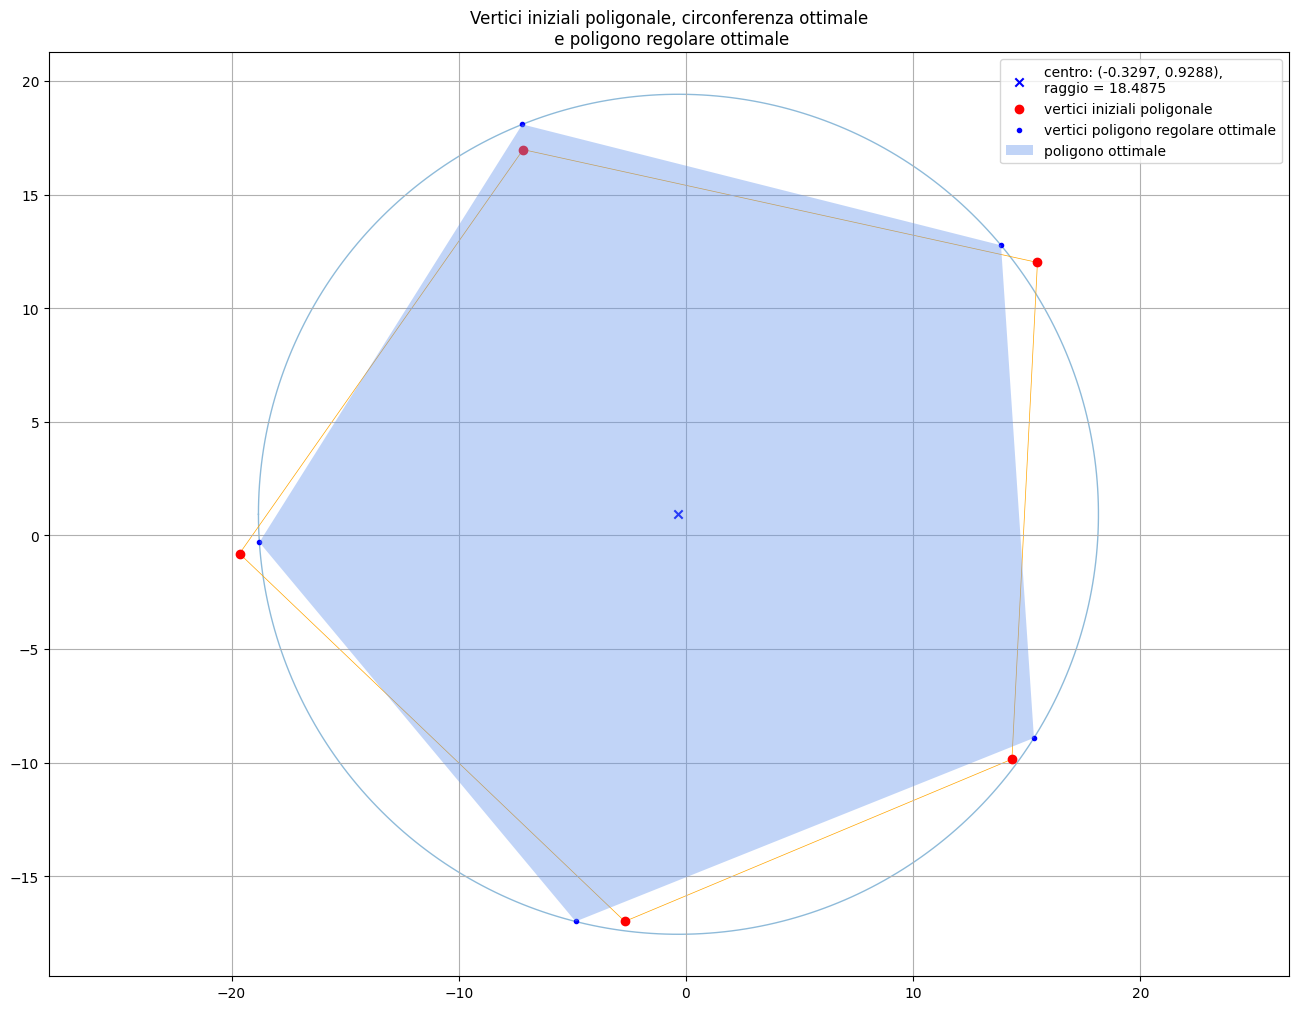

In [28]:
figura = plt.figure(facecolor = 'white')
plt.rcParams['figure.figsize'] = [16, 12]
ax = plt.axes()
ax.set_axisbelow(True)
plt.axis('equal')
plt.grid()
plt.plot([dati_x, np.roll(dati_x, 1)], [dati_y, np.roll(dati_y, 1)], linewidth = .5, c = 'orange', zorder = -1)
plt.plot(xp, yp, linewidth = 1, alpha = 0.5, zorder = -2)
plt.scatter(xc, yc, c ='blue', marker = 'x', label = 'centro: ({0:6.4f}, {1:6.4f}),\nraggio = {2:6.4f}'.format(xc,yc,r))
plt.scatter(dati_x, dati_y, c = 'red', label = 'vertici iniziali poligonale', marker = 'o')
plt.scatter(x_pol_reg, y_pol_reg, c = 'blue', label = 'vertici poligono regolare ottimale', marker = '.')
plt.fill(x_pol_reg, y_pol_reg, facecolor = 'cornflowerblue', alpha = 0.4, label = 'poligono ottimale')
plt.legend(loc = 'best', labelspacing = 0.5)
plt.title('Vertici iniziali poligonale, circonferenza ottimale\n e poligono regolare ottimale')
plt.show()